# Import

In [26]:
import pandas as pd
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report, roc_auc_score, average_precision_score,
    precision_recall_curve, roc_curve,
    confusion_matrix, f1_score, recall_score, precision_score, accuracy_score,
    ConfusionMatrixDisplay, brier_score_loss
)
from sklearn.calibration import calibration_curve
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier
from sklearn.ensemble import HistGradientBoostingClassifier,  RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Data exploration

In [50]:
out_dir = Path("..")  / "heart_failure_clinical_records_dataset.csv"
FIG_DIR = Path("..")/ "reports/figures"
data = pd.read_csv(out_dir)

In [28]:
data.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [29]:
na = data.isna().sum()
print(na)

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64


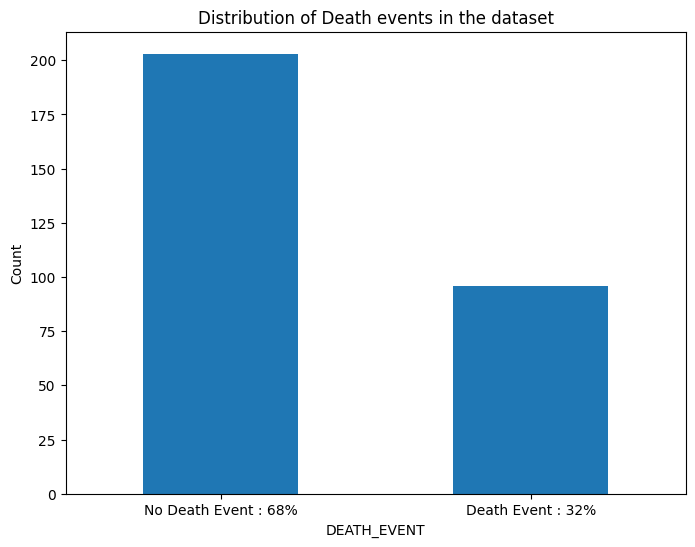

In [ ]:
plt.figure(figsize = (8,6))
data["DEATH_EVENT"].value_counts().plot(kind="bar")
percentage_death = data["DEATH_EVENT"].value_counts(normalize=True)[1] 
percentage_nodeath = data["DEATH_EVENT"].value_counts(normalize=True)[0] 
plt.xticks(ticks=[0,1], labels=[f"No Death Event : {percentage_nodeath:.0%}", f"Death Event : {percentage_death:.0%}"], rotation=0)
plt.ylabel("Count")
plt.title("Distribution of Death events in the dataset")
plt.show()

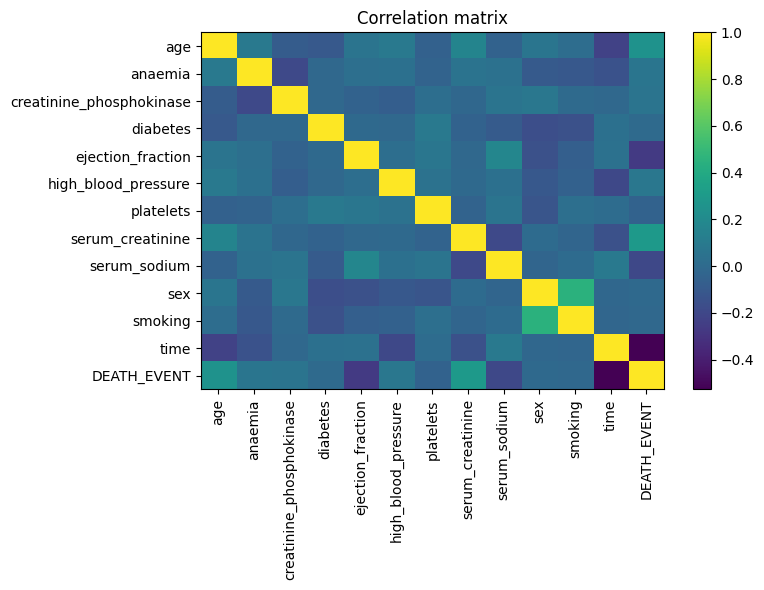

In [ ]:
num_cols = [c for c in data.columns if c != "DEATH_EVENT" and pd.api.types.is_numeric_dtype(data[c])]
corr = data[num_cols + ["DEATH_EVENT"]].corr(numeric_only=True)

plt.figure(figsize=(8,6))
plt.imshow(corr, aspect="auto")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Correlation matrix")
plt.colorbar()
plt.tight_layout()
plt.show()


# Define Dataset / models

In [32]:
X = data.drop(columns=["DEATH_EVENT"])
y = data["DEATH_EVENT"]

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [34]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
w_pos = neg / max(pos, 1)

In [35]:
models = {
    "regression": LogisticRegression(class_weight = "balanced", random_state = 42, max_iter=1000), # class weight to handle class imbalance
    "decision_tree": DecisionTreeClassifier(max_depth= 4, class_weight = "balanced", random_state = 42), # max_depth : control tree depth to avoid overfiting 
    "random_forest": RandomForestClassifier(n_estimators=600,# n_estimators : number of trees in the forest
                                            min_samples_leaf=2, # min_samples_leaf : number of samples required to be at a leaf node
                                            class_weight = "balanced", random_state=42,
                                            n_jobs=-1),# n_jobs = -1 to uses all cpus
    "hist_gradient_boosting": HistGradientBoostingClassifier(max_depth=3,learning_rate=0.05,max_iter=600, random_state = 42), # max_iter : number of trees
    "xgboost": XGBClassifier(n_estimators=800,max_depth=3,learning_rate=0.05,
                            subsample=0.9,# subsample : fraction of samples to be used for each tree
                            colsample_bytree=0.9,# colsample_bytree : fraction of features to be used for each tree
                            reg_lambda=1.0, # reg_lambda : L2 regularization 
                            min_child_weight=1,gamma=0,random_state=42,
                            n_jobs=-1,
                            scale_pos_weight=w_pos,# scale_pos_weight : ratio of number of negative class to the positive class
                            eval_metric="logloss")
}

# Training and evaluation

In [ ]:
def evaluate_preds(y_true, y_proba, threshold = 0.5, model_name = "model"):
    y_pred = (y_proba >= threshold).astype(int)
    rep = classification_report(y_true, y_pred, output_dict=True, zero_division=0)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    return {
        "model": model_name,
        "threshold": threshold,

        "accuracy": accuracy_score(y_true, y_pred),
        "roc_auc": roc_auc_score(y_true, y_proba),
        "pr_auc": average_precision_score(y_true, y_proba),

        "precision_1": rep["1"]["precision"],
        "recall_1": rep["1"]["recall"],
        "f1_1": rep["1"]["f1-score"],

        "macro_f1": rep["macro avg"]["f1-score"],
        "weighted_f1": rep["weighted avg"]["f1-score"],

        "tn": tn, "fp": fp, "fn": fn, "tp": tp,
    }

def plot_roc_pr(y_true, y_proba, name="model"):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr)
    plt.plot([0,1], [0,1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC curve - {name}")
    plt.tight_layout()
    plt.savefig(FIG_DIR / f"roc_{name}.png", dpi=200)
    plt.show()

    prec, rec, _ = precision_recall_curve(y_true, y_proba)
    plt.figure(figsize=(5,4))
    plt.plot(rec, prec)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"PR curve - {name}")
    plt.tight_layout()
    plt.savefig(FIG_DIR / f"pr_{name}.png", dpi=200)
    plt.show()

def show_confusion(y_true, y_proba, threshold=0.5, name="model"):
    y_pred = (y_proba >= threshold).astype(int)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, values_format="d")
    plt.title(f"Confusion matrix - {name} : thr={threshold:.2f}")
    plt.tight_layout()
    plt.savefig(FIG_DIR / f"cm_{name}_thr_{threshold:.2f}.png", dpi=200)
    plt.show()

def choose_threshold_for_recall(y_true, y_proba, min_recall=0.80):
    prec, rec, thr = precision_recall_curve(y_true, y_proba)

    candidates = []
    for i in range(len(thr)):
        if rec[i] >= min_recall:
            candidates.append((thr[i], prec[i], rec[i]))

    if not candidates:
        return None

    # highest threshold while still meeting recall
    best = max(candidates, key=lambda x: x[0])
    return {"threshold": float(best[0]), "precision": float(best[1]), "recall": float(best[2])}

    

In [37]:
all_results = []
fitted_models = {}
probas = {}
for name, model in models.items():
    pipeline = Pipeline([
    # ("imputer", SimpleImputer(strategy="median")), # à utiliser si valeurs manquantes (strategy : "median", "mean", "most_frequent", "constant")
    ("scaler", StandardScaler()),
    ("model", model)
    ])
    
    sample_weight = np.where(y_train == 1, w_pos, 1.0)

    if name == "hist_gradient_boosting":
        pipeline.fit(X_train, y_train, model__sample_weight = sample_weight)
        
    else:
        pipeline.fit(X_train, y_train)
        
    y_proba = pipeline.predict_proba(X_test)[:,1]
    probas[name] = y_proba
    reports = evaluate_preds(y_test, y_proba, threshold = 0.5, model_name = name)
    all_results.append(reports)
    fitted_models[name] = pipeline
  
results_df = pd.DataFrame(all_results) 
results_df 

,model,threshold,accuracy,roc_auc,pr_auc,precision_1,recall_1,f1_1,macro_f1,weighted_f1,tn,fp,fn,tp
0,regression,0.5,0.800000,0.854942,0.741480,0.733333,0.578947,0.647059,0.753762,0.792886,37,4,8,11
1,decision_tree,0.5,0.783333,0.777920,0.679130,0.636364,0.736842,0.682927,0.759185,0.787146,33,8,5,14
2,random_forest,0.5,0.833333,0.902439,0.813424,0.800000,0.631579,0.705882,0.794802,0.827405,38,3,7,12
3,hist_gradient_boosting,0.5,0.833333,0.839538,0.745336,0.764706,0.684211,0.722222,0.801587,0.830688,37,4,6,13
4,xgboost,0.5,0.833333,0.831836,0.745589,0.846154,0.578947,0.687500,0.786932,0.823390,39,2,8,11


In [38]:
thr_results = []
for name, y_prob in probas.items():
    info = choose_threshold_for_recall(y_test, y_prob, min_recall=0.80)
    if info is None:
        continue

    thr = info["threshold"]
    row = evaluate_preds(y_test, y_prob, threshold=thr, model_name=f"{name}_thr_recall80")
    row["chosen_threshold"] = thr
    thr_results.append(row)

thr_df = pd.DataFrame(thr_results).sort_values("precision_1", ascending=False)
thr_df

,model,threshold,accuracy,roc_auc,pr_auc,precision_1,recall_1,f1_1,macro_f1,weighted_f1,tn,fp,fn,tp,chosen_threshold
2,random_forest_thr_recall80,0.288792,0.816667,0.902439,0.813424,0.666667,0.842105,0.744186,0.800664,0.821373,33,8,3,16,0.288792
0,regression_thr_recall80,0.256349,0.733333,0.854942,0.741480,0.551724,0.842105,0.666667,0.722222,0.742593,28,13,3,16,0.256349
3,hist_gradient_boosting_thr_recall80,0.005272,0.683333,0.839538,0.745336,0.500000,0.842105,0.627451,0.676044,0.693862,25,16,3,16,0.005272
4,xgboost_thr_recall80,0.010315,0.633333,0.831836,0.745589,0.457143,0.842105,0.592593,0.629630,0.643210,22,19,3,16,0.010315
1,decision_tree_thr_recall80,0.035298,0.333333,0.777920,0.679130,0.309091,0.894737,0.459459,0.294947,0.234626,3,38,2,17,0.035298


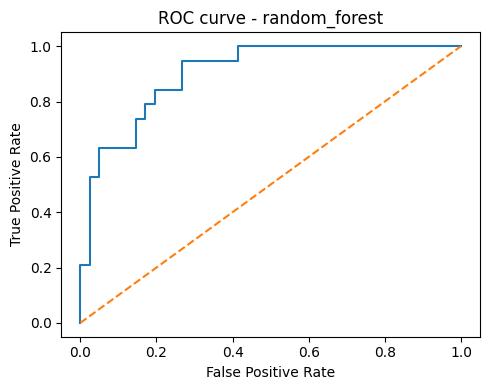

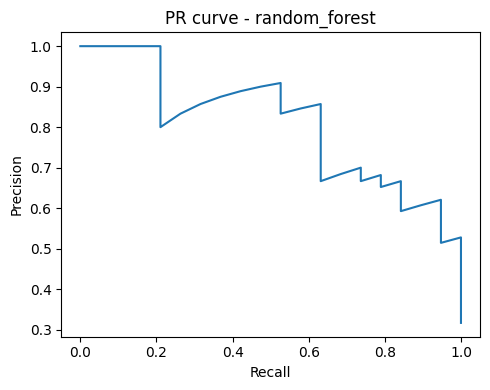

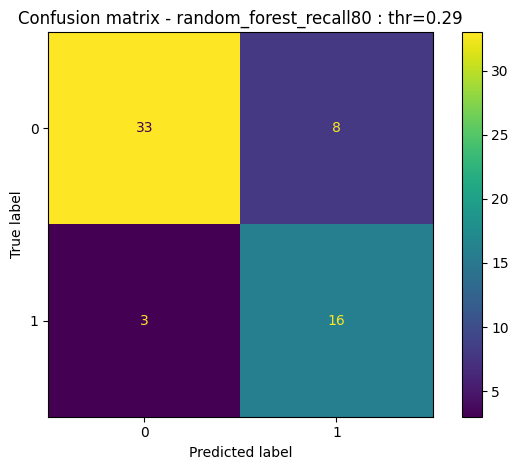

In [51]:
best_name = "random_forest"
best_threshold = thr_df[thr_df["model"] == "random_forest_thr_recall80"]["chosen_threshold"].values[0]

plot_roc_pr(y_test, probas[best_name], name="random_forest")
show_confusion(y_test, probas[best_name], threshold=best_threshold, name="random_forest_recall80")


# Interpretation

In [ ]:
best_model = fitted_models["random_forest"]

perm = permutation_importance(
    best_model, X_test, y_test,
    n_repeats=25, # number of times a feature is randomly shuffled 
    random_state=42,
    scoring="average_precision"
)

perm_df = pd.DataFrame({
    "feature": X.columns,
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values("importance_mean", ascending=False)

perm_df.head(10)


,feature,importance_mean,importance_std
11,time,0.323482,0.064764
7,serum_creatinine,0.056442,0.043344
4,ejection_fraction,0.036382,0.028617
2,creatinine_phosphokinase,0.034143,0.020723
0,age,0.015320,0.023044
8,serum_sodium,0.014149,0.021442
5,high_blood_pressure,0.003057,0.005350
9,sex,0.002628,0.005361
10,smoking,0.001480,0.005032
3,diabetes,-0.000457,0.004024


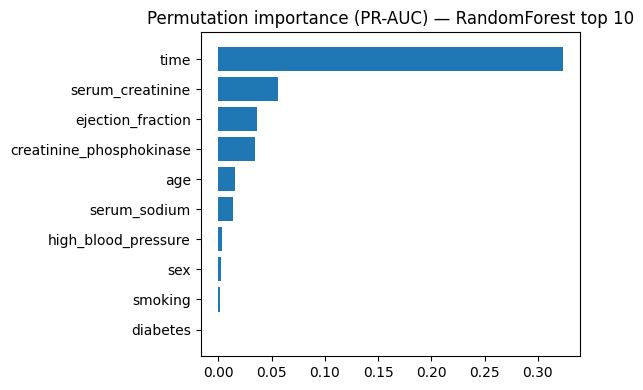

In [52]:
top_perm_df = perm_df.head(10).iloc[::-1]
plt.figure(figsize=(6,4))
plt.barh(top_perm_df["feature"], top_perm_df["importance_mean"])
plt.title("Permutation importance (PR-AUC) — RandomForest top 10")
plt.tight_layout()
plt.savefig(FIG_DIR / "rf_permutation_importance.png", dpi=200)
plt.show()

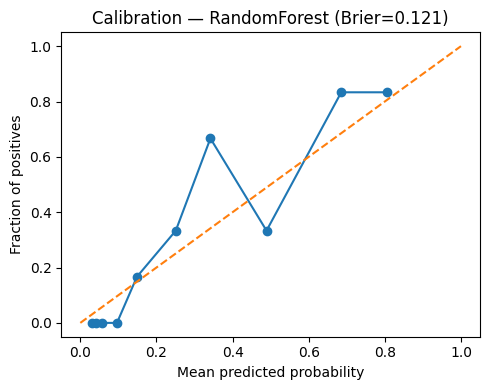

In [53]:
brier = brier_score_loss(y_test, probas[best_name])
frac_pos, mean_pred = calibration_curve(y_test, probas[best_name], n_bins=10, strategy="quantile")

plt.figure(figsize=(5,4))
plt.plot(mean_pred, frac_pos, marker="o")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title(f"Calibration — RandomForest (Brier={brier:.3f})")
plt.tight_layout()
plt.savefig(FIG_DIR / "calibration_curve.png", dpi=200)
plt.show()

